# CNN training for pattern recognition on Range-Doppler Heatmap (3D) and Static Range-Azimuth Heatmap (2D)

In [1]:
#import tensorflow.keras
import os
from os import listdir
from os.path import isdir, join
import numpy as np
from keras import layers, models, metrics
from subprocess import check_output
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import keras
from keras.models import Sequential
from keras.layers import Conv3D,MaxPooling3D,Dense,Flatten,Dropout
from keras.optimizers import Adam,SGD
from keras.callbacks import TensorBoard
from keras.callbacks import EarlyStopping, ModelCheckpoint

## Gathering the databases

In [2]:
# Doppler CNN files paths
feature_sets_path  = os.getcwd() + '\\Features\\'
filename_dop = 'all_targets_doppler_1211_6587'
features_filename_dop = filename_dop + '.npz'
dop_model_filename = filename_dop + '.h5'

In [3]:
# Azimuth CNN files paths
filename_az = 'all_targets_azimuth_0_37230'
features_filename_az = filename_az + '.npz'
az_model_filename = filename_az + '.h5'

In [4]:
# Load feature sets
features_set_dop = np.load(join(feature_sets_path, features_filename_dop))
print('features for doppler set:',features_set_dop.files)

features_set_az = np.load(join(feature_sets_path, features_filename_az))
print('features for azimuth set:',features_set_az.files)

features for doppler set: ['x_train', 'y_train', 'x_val', 'y_val', 'x_test', 'y_test']
features for azimuth set: ['x_train', 'y_train', 'x_val', 'y_val', 'x_test', 'y_test']


In [5]:
# Assign Doppler feature sets
x_train_dop = features_set_dop['x_train']
y_train_dop = features_set_dop['y_train']
x_val_dop = features_set_dop['x_val']
y_val_dop = features_set_dop['y_val']
x_test_dop = features_set_dop['x_test']
y_test_dop = features_set_dop['y_test']

In [6]:
# Assign Azimuth feature sets
x_train_az = features_set_az['x_train']
y_train_az = features_set_az['y_train']
x_val_az = features_set_az['x_val']
y_val_az = features_set_az['y_val']
x_test_az = features_set_az['x_test']
y_test_az = features_set_az['y_test']

In [7]:
# Look at tensor dimensions
print('Doppler:')
print('training input shape :',x_train_dop.shape)
print('validation input shape :',x_val_dop.shape)
print('test input shape :',x_test_dop.shape)

print('Azimuth:')
print('training input shape :',x_train_az.shape)
print('validation input shape :',x_val_az.shape)
print('test input shape :',x_test_az.shape)

Doppler:
training input shape : (15438, 256, 4)
validation input shape : (3286, 256, 4)
test input shape : (3286, 256, 4)
Azimuth:
training input shape : (129024, 31)
validation input shape : (27648, 31)
test input shape : (27648, 31)


In [8]:
# Sample shape
NUMBER_ROWS_DOP = 31
NUMBER_COlUMNS_DOP = 256
NUMBER_ROWS_AZ = NUMBER_COlUMNS_DOP
NUMBER_COlUMNS_AZ = NUMBER_ROWS_DOP
DEPTH = 4

In [9]:
# CNN for TF expects (batch (lote), height, width, channels)
# So we reshape the input tensors with a "color" channel of ''

# Doppler
x_train_dop = x_train_dop.reshape(int(x_train_dop.shape[0]/(NUMBER_ROWS_DOP)),
                          NUMBER_ROWS_DOP,
                          NUMBER_COlUMNS_DOP,
                          DEPTH,
                          1)
x_val_dop = x_val_dop.reshape(int(x_val_dop.shape[0]/(NUMBER_ROWS_DOP)),
                      NUMBER_ROWS_DOP,
                      NUMBER_COlUMNS_DOP,
                      DEPTH,
                      1)
x_test_dop = x_test_dop.reshape(int(x_test_dop.shape[0]/(NUMBER_ROWS_DOP)),
                        NUMBER_ROWS_DOP,
                        NUMBER_COlUMNS_DOP,
                        DEPTH,
                        1)

print('number of training samples :',x_train_dop.shape[0])
print('number of validation samples :',x_val_dop.shape[0])
print('number of test samples :',x_test_dop.shape[0])

sample_shape_dop = x_test_dop.shape[1:]
print('sample shape :',sample_shape_dop)

number of training samples : 498
number of validation samples : 106
number of test samples : 106
sample shape : (31, 256, 4, 1)


In [10]:
# Azimuth
x_train_az = x_train_az.reshape(int(x_train_az.shape[0]/(NUMBER_ROWS_AZ)),
                          NUMBER_ROWS_AZ,
                          NUMBER_COlUMNS_AZ,
                          1)
x_val_az = x_val_az.reshape(int(x_val_az.shape[0]/(NUMBER_ROWS_AZ)),
                          NUMBER_ROWS_AZ,
                          NUMBER_COlUMNS_AZ,
                          1)
x_test_az = x_test_az.reshape(int(x_test_az.shape[0]/(NUMBER_ROWS_AZ)),
                          NUMBER_ROWS_AZ,
                          NUMBER_COlUMNS_AZ,
                          1)

print('number of training samples :',x_train_az.shape[0])
print('number of validation samples :',x_val_az.shape[0])
print('number of test samples :',x_test_az.shape[0])

sample_shape_az = x_test_az.shape[1:]
print('sample shape :',sample_shape_az)

number of training samples : 504
number of validation samples : 108
number of test samples : 108
sample shape : (256, 31, 1)


## 3D Model construction and training (Range-Doppler Heatmap pattern recognition)

### Model Construction

In [11]:
# Build model
# Based on: https://www.geeksforgeeks.org/python-image-classification-using-keras/
model_dop = models.Sequential()

# Convolution filters
model_dop.add(layers.Conv3D(filters=2, kernel_size=(2,2,2), kernel_initializer='random_normal', activation='relu', padding = 'same', input_shape=sample_shape_dop, name = 'Conv3D_layer1'))
model_dop.add(layers.MaxPooling3D(pool_size=(2,2,1), name = 'Pooling_layer1'))
model_dop.add(Dropout(0.5))

model_dop.add(Conv3D(filters=4, kernel_size=(2,2,2), kernel_initializer='random_normal', activation='relu', padding = 'same', name = 'Conv3D_layer2'))
model_dop.add(MaxPooling3D(pool_size=(2,2,1), name = 'Pooling_layer2'))
model_dop.add(Dropout(0.5))

model_dop.add(Conv3D(filters=8, kernel_size=(2,2,2), kernel_initializer='random_normal', activation='relu', padding = 'same', name = 'Conv3D_layer3'))
model_dop.add(MaxPooling3D(pool_size=(2,2,1), name = 'Pooling_layer3'))
model_dop.add(Dropout(0.5))

# Classifier
model_dop.add(Flatten())
model_dop.add(Dense(128, kernel_initializer='random_normal', activation='relu'))
model_dop.add(Dropout(0.5))
model_dop.add(Dense(32, kernel_initializer='random_normal', activation='relu'))
model_dop.add(Dropout(0.5))


# Check Number of Classes Before Training
model_dop.add(Dense(2, activation='sigmoid'))

# Display model
model_dop.layers
model_dop.summary()

c:\Users\Iman\Desktop\Stage\code\myenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Conv3D_layer1 (Conv3D)          │ (None, 31, 256, 4, 2)  │            18 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Pooling_layer1 (MaxPooling3D)   │ (None, 15, 128, 4, 2)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 15, 128, 4, 2)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv3D_layer2 (Conv3D)          │ (None, 15, 128, 4, 4)  │            68 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Pooling_layer2 (MaxPooling3D)   │ (None, 7, 64, 4, 4)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 64, 4, 4)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv3D_layer3 (Conv3D)          │ (None, 7, 64, 4, 8)    │           264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Pooling_layer3 (MaxPooling3D)   │ (None, 3, 32, 4, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 3, 32, 4, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       393,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 397,888 (1.52 MB)

 Trainable params: 397,888 (1.52 MB)

 Non-trainable params: 0 (0.00 B)

### Model training

In [12]:
# PatientEearly Stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20, restore_best_weights=True)

# Add training parameters to model
model_dop.compile(loss='sparse_categorical_crossentropy',
             optimizer=keras.optimizers.Adam(learning_rate=0.0001), #SGD, RMSProp, Adam, nadam
             loss_weights=0.01,
             metrics=['accuracy'])

# Train
history_dop = model_dop.fit(x_train_dop,
                   y_train_dop,
                   epochs=250,
                   batch_size=4,
                   validation_data=(x_val_dop,y_val_dop),
                   callbacks = [es])

Epoch 1/250
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.5121 - loss: 0.0069 - val_accuracy: 0.3774 - val_loss: 0.0069
Epoch 2/250
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.5448 - loss: 0.0069 - val_accuracy: 0.3774 - val_loss: 0.0070
Epoch 3/250
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.5246 - loss: 0.0069 - val_accuracy: 0.3774 - val_loss: 0.0070
Epoch 4/250
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.5401 - loss: 0.0069 - val_accuracy: 0.3774 - val_loss: 0.0070
Epoch 5/250
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.5002 - loss: 0.0069 - val_accuracy: 0.3774 - val_loss: 0.0070
Epoch 6/250
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.4993 - loss: 0.0069 - val_accuracy: 0.3774 - val_loss: 0.0070
Epoch 7/250
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.5184 - loss: 0.0069 - val_accuracy: 0.3774 - val_loss: 0.0070
Epoch 8/250
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.5357 - loss: 0.0068 - 

### Plotting results

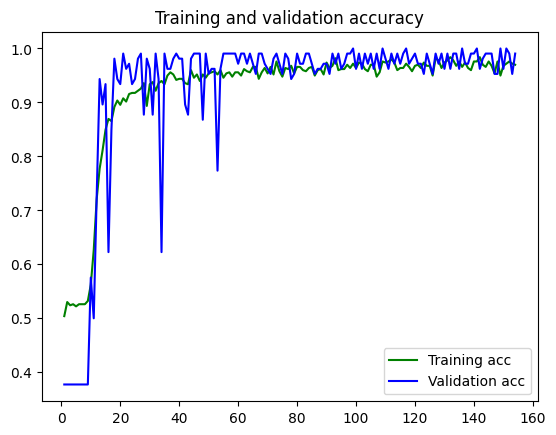

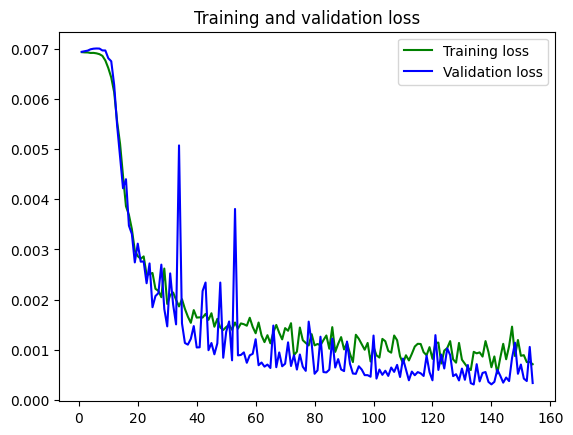

In [13]:
# Plot results
import matplotlib.pyplot as plt

acc = history_dop.history['accuracy']
val_acc = history_dop.history['val_accuracy']
loss = history_dop.history['loss']
val_loss = history_dop.history['val_loss']
#recall = history.history['recall_1']
#val_recall = history.history['val_recall_1']
#precision = history.history['precision']
#val_precision = history.history['val_precision']


epochs = range(1, len(acc) + 1)

# Plot the training and validation accuracy
plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

# Plot the training and validation loss
plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [14]:
# Model evaluation on test set
test_loss, test_acc = model_dop.evaluate(x_test_dop, y_test_dop, verbose=2)

4/4 - 0s - 28ms/step - accuracy: 0.9906 - loss: 4.5667e-04


In [15]:
models.save_model(model_dop, feature_sets_path + '\\' + dop_model_filename)

print('saved model path :',feature_sets_path + '/' + dop_model_filename)

saved model path : c:\Users\Iman\Desktop\Stage\code\2sensors\Features\/all_targets_doppler_1211_6587.h5


## 2D Model construction and training

### Model construction

In [16]:
# Build model
# Based on: https://www.geeksforgeeks.org/python-image-classification-using-keras/
model_az = models.Sequential()

# Convolution filters
model_az.add(layers.Conv2D(filters=4, kernel_size=(3,3), kernel_initializer='random_normal', activation='relu', padding = 'same', input_shape=sample_shape_az, name = 'Conv2D_layer1'))
model_az.add(layers.MaxPooling2D(pool_size=(2,2), name = 'Pooling_layer1'))

model_az.add(layers.Conv2D(filters=16, kernel_size=(3,3), kernel_initializer='random_normal', activation='relu', padding = 'same', name = 'Conv2D_layer2'))
model_az.add(layers.MaxPooling2D(pool_size=(2,2), name = 'Pooling_layer2'))

model_az.add(layers.Conv2D(filters=32, kernel_size=(3,3), kernel_initializer='random_normal', activation='relu', padding = 'same', name = 'Conv2D_layer3'))
model_az.add(layers.MaxPooling2D(pool_size=(2,2), name = 'Pooling_layer3'))

# Classifier
model_az.add(Flatten())
model_az.add(Dense(128, kernel_initializer='random_normal', activation='relu'))
model_az.add(Dropout(0.5))
model_az.add(Dense(32, kernel_initializer='random_normal', activation='relu'))
model_az.add(Dropout(0.5))

# Check Number of Classes Before Training
model_az.add(Dense(2, activation='sigmoid'))

# Display model
model_az.layers
model_az.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Conv2D_layer1 (Conv2D)          │ (None, 256, 31, 4)     │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Pooling_layer1 (MaxPooling2D)   │ (None, 128, 15, 4)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2D_layer2 (Conv2D)          │ (None, 128, 15, 16)    │           592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Pooling_layer2 (MaxPooling2D)   │ (None, 64, 7, 16)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2D_layer3 (Conv2D)          │ (None, 64, 7, 32)      │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Pooling_layer3 (MaxPooling2D)   │ (None, 32, 3, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │       393,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 402,810 (1.54 MB)

 Trainable params: 402,810 (1.54 MB)

 Non-trainable params: 0 (0.00 B)

### Model training

In [17]:
# PatientEearly Stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20, restore_best_weights=True)

# Add training parameters to model
model_az.compile(loss='sparse_categorical_crossentropy',
             optimizer=keras.optimizers.Adam(learning_rate=0.0005), #SGD, RMSProp, Adam, nadam
             loss_weights=0.001,
             metrics=['accuracy'])

# Train
history_az = model_az.fit(x_train_az,
                   y_train_az,
                   epochs=500,
                   batch_size=2,
                   validation_data=(x_val_az,y_val_az),
                   callbacks = [es])

Epoch 1/500
252/252 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.5402 - loss: 0.0059 - val_accuracy: 1.0000 - val_loss: 6.8971e-05
Epoch 2/500
252/252 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9151 - loss: 1.9034e-04 - val_accuracy: 1.0000 - val_loss: 3.7320e-06
Epoch 3/500
252/252 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9787 - loss: 5.8589e-05 - val_accuracy: 1.0000 - val_loss: 4.0491e-07
Epoch 4/500
252/252 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9756 - loss: 5.6129e-05 - val_accuracy: 1.0000 - val_loss: 2.6223e-08
Epoch 5/500
252/252 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9955 - loss: 1.7664e-05 - val_accuracy: 1.0000 - val_loss: 3.9670e-09
Epoch 6/500
252/252 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 1.0000 - loss: 1.3031e-05 - val_accuracy: 1.0000 - val_loss: 1.0707e-10
Epoch 7/500
252/252 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9972 - loss: 8.5804e-06 - val_accuracy: 1.0000 - val_loss: 9.9341e-12
Epoch 8/500
252/252 ━━━━━━━━━━━━━━━━━━━━ 2s 6

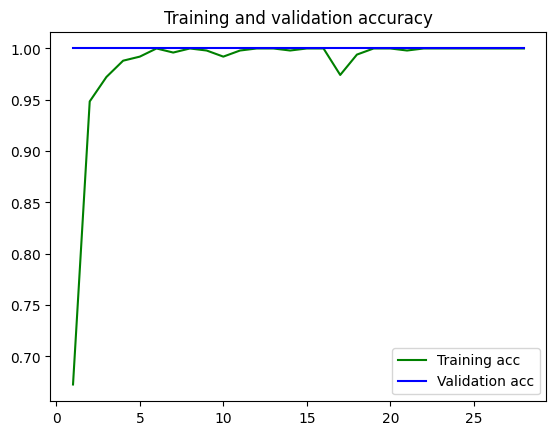

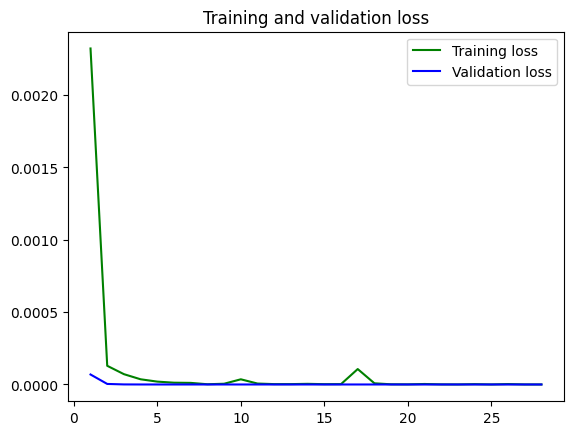

In [18]:
# Plot results
import matplotlib.pyplot as plt

acc = history_az.history['accuracy']
val_acc = history_az.history['val_accuracy']
loss = history_az.history['loss']
val_loss = history_az.history['val_loss']
#recall = history.history['recall_1']
#val_recall = history.history['val_recall_1']
#precision = history.history['precision']
#val_precision = history.history['val_precision']


epochs = range(1, len(acc) + 1)

# Plot the training and validation accuracy
plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

# Plot the training and validation loss
plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [19]:
# Model evaluation on test set
test_loss, test_acc = model_az.evaluate(x_test_az, y_test_az, verbose=2)

4/4 - 0s - 48ms/step - accuracy: 1.0000 - loss: 0.0000e+00


In [20]:
models.save_model(model_az, feature_sets_path + '\\' + az_model_filename)

print('saved model path :',feature_sets_path + '/' + az_model_filename)

saved model path : c:\Users\Iman\Desktop\Stage\code\2sensors\Features\/all_targets_azimuth_0_37230.h5


## Confusion matrix

In [21]:
import seaborn as sns
import tensorflow as tf


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step


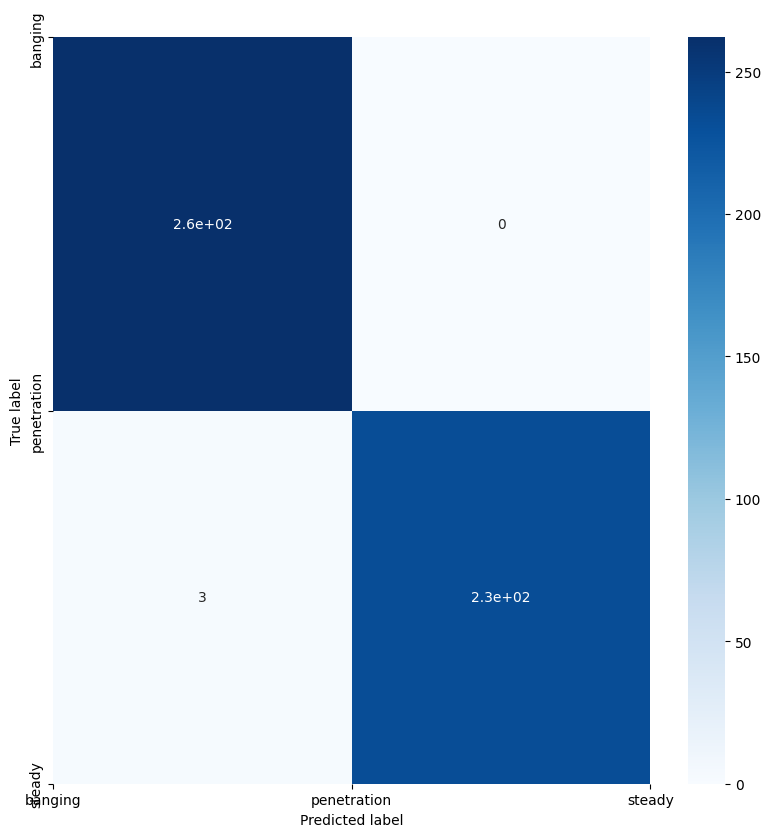

In [22]:
y_true=y_train_dop
predict_y=model_dop.predict(x_train_dop)
y_pred=np.argmax(predict_y,axis=1)

classes = [0,1]
con_mat = tf.math.confusion_matrix(labels=y_true, predictions=y_pred).numpy()
con_mat_norm = np.around(con_mat.astype('float')) #/ con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
con_mat_df = pd.DataFrame(con_mat_norm,
                     index = classes,
                     columns = classes)

figure = plt.figure(figsize=(8, 8))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.xticks([0,1,2],['banging', 'penetration','steady'])
plt.yticks([0,1,2],['banging', 'penetration','steady'])
plt.show()

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


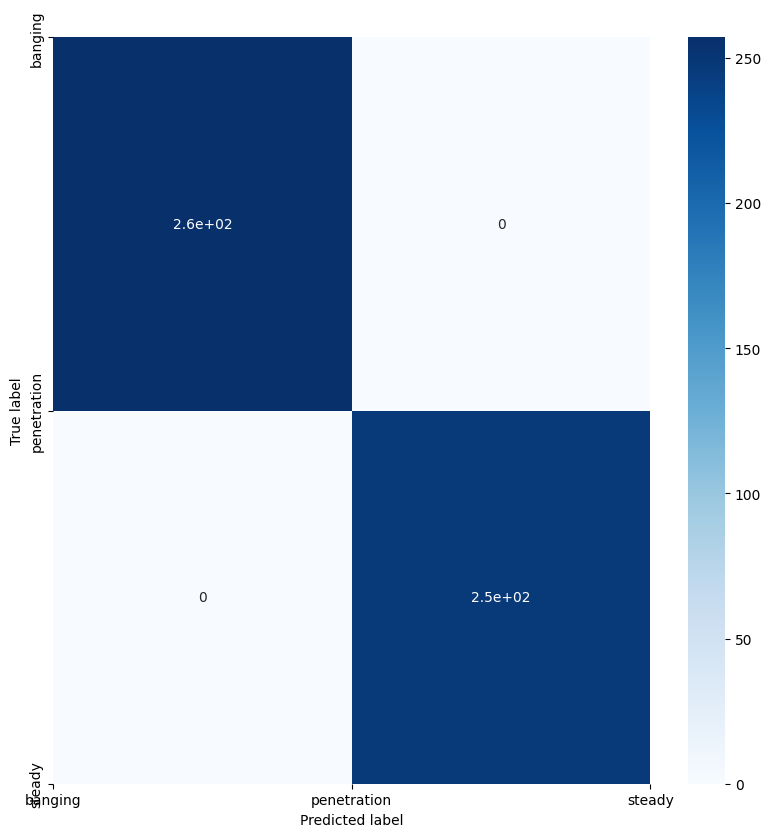

In [23]:
0.
y_true=y_train_az
predict_y=model_az.predict(x_train_az)
y_pred=np.argmax(predict_y,axis=1)

classes = [0,1]
con_mat = tf.math.confusion_matrix(labels=y_true, predictions=y_pred).numpy()
con_mat_norm = np.around(con_mat.astype('float')) #/ con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
con_mat_df = pd.DataFrame(con_mat_norm,
                     index = classes,
                     columns = classes)

figure = plt.figure(figsize=(8, 8))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.xticks([0,1,2],['banging', 'penetration','steady'])
plt.yticks([0,1,2],['banging', 'penetration','steady'])
plt.show()


In [24]:
# Prediction test with unclassified parameters
import scipy.interpolate as spi

# Load archive with the data to be predicted, put in shape with preparing_dataset_1folder
test_npz = np.load(os.getcwd()+'\\all_targets_0_13017_test_classes_55.npz')
test_in = test_npz['x_test']                                  

print(test_in.shape)
test_in_reshape = test_in.reshape(int(test_in.shape[0]/(NUMBER_ROWS_AZ)),                  # Resize with sample shape
                          NUMBER_ROWS_AZ,
                          NUMBER_COlUMNS_AZ,
                          1)

print('number of samples :',test_in_reshape.shape[0])
print('test samples shape :',test_in_reshape.shape[1:])

# Prediction on test sample pack
label = model_az.predict(test_in_reshape)
num_samples = test_in_reshape.shape[0]

# Loop throught the sample pack to display some of the predictions
for i in range (0,num_samples,10):
    print("Predicted Class for sample",i,"(0-idle, 1-presence) \n0 : ",label[i][0],"\n1 : ",label[i][1])    # Print predicted class
    sample = test_in[128*i:128*(i+1),:].reshape(
                          NUMBER_ROWS_AZ,
                          NUMBER_COlUMNS_AZ)
    range_res = 0.0436
    range_bins = sample.shape[0]
    angle_bins = sample.shape[1]
    theta = np.arcsin(np.linspace(-angle_bins / 2 + 1, angle_bins / 2 - 1, angle_bins) * (2 / angle_bins))  # Angular linear space for plotting
    range = np.linspace(0, range_bins - 1, range_bins) * range_res                                          # Range linear space for plotting
    range = np.maximum(range,0)                                                                                 # Keep only positive range value (later add range bias correction)
    range_depth = range_bins * range_res                                                         
    range_width, grid_res = range_depth/2, 64

    # Grid construction
    posX = np.outer(range, np.sin(theta))
    posY = np.outer(range, np.cos(theta))
    xlin = np.linspace(-np.floor(range_width), np.ceil(range_width), angle_bins)
    ylin = np.linspace(0, range_depth, range_bins)
    xgrid, ygrid = np.meshgrid(xlin, ylin)
    ra_grid = spi.griddata((posX.flatten(), posY.flatten()), sample.flatten(),(xgrid, ygrid), method='cubic')
    grid_init = 1
        
    hmplot = plt.contourf(xlin,ylin,sample,cmap='Spectral_r')
    plt.title(i)
    plt.show()
    #print("Expected prediction : ",expected[i],"\n")


"""     fig, subs = plt.subplots(2,2)
    for x in range(0,4,1): 
        f = sample[:,:,x]
        # read the csv file
        if (x < 2):
            subs[x][0].imshow(f, cmap='Spectral_r', interpolation='nearest', aspect='auto')
        else:
            subs[x-2][1].imshow(f, cmap='Spectral_r', interpolation='nearest', aspect='auto') """ #Doppler plotting

FileNotFoundError: [Errno 2] No such file or directory: 'c:\\Users\\Iman\\Desktop\\Stage\\code\\2sensors\\all_targets_0_13017_test_classes_55.npz'